# Behavioral testing and evaluation of the Prod2vec model on Coveo dataset

Metrics like Hit Rate provide only a partial picture of the expected behavior of recommenders in the wild: two models with very similar accuracy can have very different behavior on, say, the long-tail, or model A can be better than model B overall, but at the expense of providing disastrous performance on a set of inputs that are particularly important in production. Metrics such as coverage, serendipity, and bias have been therefore proposed to capture other aspects of the behaviors of RSs, but they still fall short of what is needed to debug RSs in production, or provide any guarantee that a model will be reliable when released.

**Dataset** - This tutorial shows how easy it is to run behavioral tests on a target dataset, in this case a wrapper around a large e-commerce dataset (the [Coveo Data Challenge dataset](https://github.com/coveooss/SIGIR-ecom-data-challenge)).

**Use case** - Complementary items. We are targeting a "complementary items" use cases, such as for example a cart recommender. *if a shopper added item X to the cart, what is she likely to add next?*

**Model** - We train a simple, yet effective prod2vec baseline [model](https://arxiv.org/abs/2007.14906), re-using for convenience a "training embedding" function. Word2vec algorithm is used for embedding over product SKU sequences.

### Flow diagram
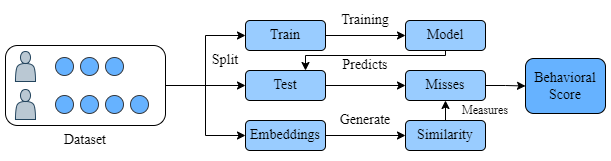

*Sample workflow for behavioral tests. Starting with shopping data (left), the dataset split and model training mimic the usual training loop. We also create a latent space, which is used to measure the relationships between inputs, ground truths and predictions, such as how far misses are from ground truths. Since a session can be viewed as a sequence of items or features (brands), we can use the same method to create embeddings for different tests.*

### Inputs and outputs

**Inputs:**

1. Model `RecModel`
2. Dataset `RecDataset`
    - Public datasets - Coveo, MSD, MovieLens
3. Use Case `RecTask`
    - Similar items - {GT:👞} → {Pred:👟} is ✅, but {GT:👞} → {Pred:🩳} is 🟥
    - Complementary items - {GT:💻} → {Pred:⌨️} is ✅, but {GT:⌨️} → {Pred:💻} is 🟥
    - Session-based recommendations
4. Behavioral Tests `RecTest`
5. List of behavioral tests `RecList`

**Outputs:**

- Results of behavioral tests.

### Modules

- **P2VRecModel**: is a very basic recommender that builds a space of products and use Knn to run predictions
- **CoveoDataset**: is the dataset we are going to play with
- **train_embeddings**: is a function that allows us to train prod2vec embeddings
- **CoveoCartRecList**: is the RecList! this is a pre-made RecList for you to evaluate your models (or our P2VRecModel, in this tutorial) on the Coveo Dataset.

## Setup

In [ ]:
!pip install gensim==4.0.1
!pip install jinja2==3.0.2
!pip install algoliasearch==2.6.0
!pip install appdirs==1.4.4
!pip install wget==3.2
!pip install pytest==6.2.5
!pip install requests==2.22.0
!pip install tqdm==4.62.3
!pip install matplotlib==3.4.3
!pip install numpy==1.21.2
!pip install pathos==0.2.8
!pip install flask==2.0.2
!pip install networkx==2.6.3
!pip install python-Levenshtein==0.12.2

In [ ]:
import gensim
from abc import ABC, abstractmethod
import ast
from datetime import datetime
import inspect
import os
from abc import ABC, abstractmethod
from functools import wraps
from pathlib import Path
import time
import json
import tempfile
import zipfile
import random
import requests
from tqdm import tqdm
from enum import Enum
from typing import List
import itertools
import numpy as np
import collections
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from statistics import mean
import json
import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path
from collections import Counter, defaultdict
import math

## Dataset

In [ ]:
COVEO_INTERACTION_DATASET_S3_URL = 'https://reclist-datasets-6d3c836d-6djh887d.s3.us-west-2.amazonaws.com/coveo_sigir.zip'

In [ ]:
def download_with_progress(url, destination):
    """
    Downloads a file with a progress bar
    :param url: url from which to download from
    :destination: file path for saving data
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    with tqdm.wrapattr(open(destination, "wb"), "write",
                       miniters=1, desc=url.split('/')[-1],
                       total=int(response.headers.get('content-length', 0))) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)


def get_cache_directory():
    """
    Returns the cache directory on the system
    """
    cache_dir = '/content/coveo_reclist'

    Path(cache_dir).mkdir(parents=True, exist_ok=True)

    return cache_dir


class Dataset(Enum):
    COVEO = 'coveo'
    COVEO_INTERNAL = 'coveo-internal'

In [ ]:
class RecDataset(ABC):
    """
    Implements an abstract class for the dataset
    """
    def __init__(self, force_download=False):
        """
        :param force_download: allows to force the download of the dataset in case it is needed.
        :type: force_download: bool, optional
        """
        self._x_train = None
        self._y_train = None
        self._x_test = None
        self._y_test = None
        self._catalog = None
        self.force_download = force_download
        self.load()

    @abstractmethod
    def load(self):
        """
        Abstract method that should implement dataset loading
        @return:
        """
        return

    @property
    def x_train(self):
        return self._x_train

    @property
    def y_train(self):
        return self._y_train

    @property
    def x_test(self):
        return self._x_test

    @property
    def y_test(self):
        return self._y_test

    @property
    def catalog(self):
        return self._catalog

In [ ]:
class CoveoDataset(RecDataset):
    """
    Coveo SIGIR data challenge dataset
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def load(self):
        cache_directory = get_cache_directory()
        filename = os.path.join(cache_directory, "coveo_sigir.zip")  # TODO: make var somewhere

        if not os.path.exists(filename) or self.force_download:
            download_with_progress(COVEO_INTERACTION_DATASET_S3_URL, filename)

        with tempfile.TemporaryDirectory() as temp_dir:
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)
            with open(os.path.join(temp_dir, 'dataset.json')) as f:
                data = json.load(f)

        self._x_train = data["x_train"]
        self._y_train = None
        self._x_test = data["x_test"]
        self._y_test = data["y_test"]
        self._catalog = data["catalog"]

## Model

In [ ]:
def train_embeddings(
    sessions: list,
    min_c: int = 3,
    size: int = 48,
    window: int = 5,
    iterations: int = 15,
    ns_exponent: float = 0.75,
    is_debug: bool = True):
    """
    Train CBOW to get product embeddings with sensible defaults (https://arxiv.org/abs/2007.14906).
    :param sessions: list of lists, as user sessions are list of interactions
    :param min_c: minimum frequency of an event for it to be calculated for product embeddings
    :param size: output dimension
    :param window: window parameter for gensim word2vec
    :param iterations: number of training iterations
    :param ns_exponent: ns_exponent parameter for gensim word2vec
    :param is_debug: if true, be more verbose when training
    :return: trained product embedding model
    """
    model = gensim.models.Word2Vec(sentences=sessions,
                                   min_count=min_c,
                                   vector_size=size,
                                   window=window,
                                   epochs=iterations,
                                   ns_exponent=ns_exponent)

    if is_debug:
        print("# products in the space: {}".format(len(model.wv.index_to_key)))

    return model.wv

In [ ]:
class RecModel(ABC):
    """
    Abstract class for recommendation model
    """

    def __init__(self, model=None):
        """
        :param model: a model that can be used in the predict function
        """
        self._model = model

    @abstractmethod
    def predict(self, prediction_input: list, *args, **kwargs):
        """
        The predict function should implement the behaviour of the model at inference time.
        :param prediction_input: the input that is used to to do the prediction
        :param args:
        :param kwargs:
        :return:
        """
        return NotImplementedError

    @property
    def model(self):
        return self._model

In [ ]:
class P2VRecModel(RecModel):
    """
    Implement of the prod2vec model through the standard RecModel interface.
    Since init is ok, we just need to overwrite the prediction methods to get predictions
    out of it.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    model_name = "prod2vec"
    def predict(self, prediction_input: list, *args, **kwargs):
        """
        Implement the abstract method, accepting a list of lists, each list being
        the content of a cart: the predictions returned by the model are the top K
        items suggested to complete the cart.
        """
        predictions = []
        for _x in prediction_input:
            # we assume here that every X is a list of one-element, the product already in the cart
            # i.e. our prediction_input list is [[sku_1], [sku_3], ...]
            key_item = _x[0]['product_sku']
            nn_products = self._model.most_similar(key_item, topn=10) if key_item in self._model else None
            if nn_products:
                predictions.append([{'product_sku':_[0]} for _ in nn_products])
            else:
                predictions.append([])

        return predictions

    def get_vector(self, product_sku):
        try:
            return list(self._model.get_vector(product_sku))
        except Exception as e:
            return []

## Metrics

### Standard Metrics

In [ ]:
def statistics(x_train, y_train, x_test, y_test, y_pred):
    train_size = len(x_train)
    test_size = len(x_test)
    # num non-zero preds
    num_preds = len([p for p in y_pred if p])
    return {
        'training_set__size': train_size,
        'test_set_size': test_size,
        'num_non_null_predictions': num_preds
    }


def sample_hits_at_k(y_preds, y_test, x_test=None, k=3, size=3):
    hits = []
    for idx, (_p, _y) in enumerate(zip(y_preds, y_test)):
        if _y[0] in _p[:k]:
            hit_info = {
                'Y_TEST': [_y[0]],
                'Y_PRED': _p[:k],
            }
            if x_test:
                hit_info['X_TEST'] = [x_test[idx][0]]
            hits.append(hit_info)

    if len(hits) < size or size == -1:
        return hits
    return random.sample(hits, k=size)


def sample_misses_at_k(y_preds, y_test, x_test=None, k=3, size=3):
    misses = []
    for idx, (_p, _y) in enumerate(zip(y_preds, y_test)):
        if _y[0] not in _p[:k]:
            miss_info =  {
                'Y_TEST': [_y[0]],
                'Y_PRED': _p[:k],
            }
            if x_test:
                miss_info['X_TEST'] = [x_test[idx][0]]
            misses.append(miss_info)

    if len(misses) < size or size == -1:
        return misses
    return random.sample(misses, k=size)


def hit_rate_at_k(y_preds, y_test, k=3):
    hits = 0
    for _p, _y in zip(y_preds, y_test):
        if _y[0] in _p[:k]:
            hits += 1
    return hits / len(y_test)


def mrr_at_k(y_preds, y_test, k=3):
    """
    Computes MRR
    :param y_preds: predictions, as lists of lists
    :param y_test: target data, as lists of lists (eventually [[sku1], [sku2],...]
    :param k: top-k
    """
    rr = []
    y_test = [k[0] for k in y_test]
    for _p, _y in zip(y_preds, y_test):
        if _y in _p[:k+1]:
            rank = _p[:k+1].index(_y) + 1
            rr.append(1/rank)
        else:
            rr.append(0)
    return np.mean(rr)


def coverage_at_k(y_preds, product_data, k=3):
    pred_skus = set(itertools.chain.from_iterable(y_preds[:k]))
    all_skus = set(product_data.keys())
    nb_overlap_skus = len(pred_skus.intersection(all_skus))

    return nb_overlap_skus / len(all_skus)


def popularity_bias_at_k(y_preds, x_train, k=3):
    # estimate popularity from training data
    pop_map = collections.defaultdict(lambda : 0)
    num_interactions = 0
    for session in x_train:
        for event in session:
            pop_map[event] += 1
            num_interactions += 1
    # normalize popularity
    pop_map = {k:v/num_interactions for k,v in pop_map.items()}
    all_popularity = []
    for p in y_preds:
        average_pop = sum(pop_map.get(_, 0.0) for _ in p[:k]) / len(p) if len(p) > 0 else 0
        all_popularity.append(average_pop)
    return sum(all_popularity) / len(y_preds)

### Cosine Distance Metrics

In [ ]:
def error_by_cosine_distance(model, y_test, y_preds, k=3, bins=25, debug=False):
    if not(hasattr(model.__class__, 'get_vector') and callable(getattr(model.__class__, 'get_vector'))):
        error_msg = "Error : Model {} does not support retrieval of vector embeddings".format(model.__class__)
        print(error_msg)
        return error_msg
    misses = sample_misses_at_k(y_preds, y_test, k=k, size=-1)
    cos_distances = []
    for m in misses:
        if m['Y_PRED']:
            vector_test = model.get_vector(m['Y_TEST'][0])
            vector_pred = model.get_vector(m['Y_PRED'][0])
            if vector_pred and vector_test:
                cos_dist = cosine(vector_pred, vector_test)
                cos_distances.append(cos_dist)

    histogram = np.histogram(cos_distances, bins=bins, density=False)
    # cast to list
    histogram = (histogram[0].tolist(), histogram[1].tolist())
    # debug / viz
    if debug:
        plt.hist(cos_distances, bins=bins)
        plt.title('dist over cosine distance prod space')
        plt.show()

    return {'mean': np.mean(cos_distances), 'histogram': histogram}

def distance_to_query(model, x_test, y_test, y_preds, k=3, bins=25, debug=False):
    if not(hasattr(model.__class__, 'get_vector') and callable(getattr(model.__class__, 'get_vector'))):
        error_msg = "Error : Model {} does not support retrieval of vector embeddings".format(model.__class__)
        print(error_msg)
        return error_msg
    misses = sample_misses_at_k(y_preds, y_test, x_test=x_test, k=k, size=-1)
    x_to_y_cos = []
    x_to_p_cos = []
    for m in misses:
        if m['Y_PRED']:
            vector_x = model.get_vector(m['X_TEST'][0])
            vector_y = model.get_vector(m['Y_TEST'][0])
            vectors_p = [model.get_vector(_) for _ in m['Y_PRED']]
            c_dists =[]
            if not vector_x or not vector_y:
                continue
            x_to_y_cos.append(cosine(vector_x, vector_y))
            for v_p in vectors_p:
                if not v_p:
                    continue
                cos_dist = cosine(v_p, vector_x)
                if cos_dist:
                    c_dists.append(cos_dist)
            if c_dists:
                x_to_p_cos.append(mean(c_dists))

    h_xy = np.histogram(x_to_y_cos, bins=bins, density=False)
    h_xp = np.histogram(x_to_p_cos, bins=bins, density=False)

    h_xy = (h_xy[0].tolist(), h_xy[1].tolist())
    h_xp = (h_xp[0].tolist(), h_xp[1].tolist())

    # debug / viz
    if debug:
        plt.hist(x_to_y_cos, bins=bins, alpha=0.5)
        plt.hist(x_to_p_cos, bins=bins, alpha=0.5)
        plt.title('distribution of distance to input')
        plt.legend(['Distance from Input to Label',
                    'Distance from Input to Label'],
                   loc='upper right')
        plt.show()

    return {
        'histogram_x_to_y': h_xy,
        'histogram_x_to_p': h_xp,
        'raw_distances_x_to_y': x_to_y_cos,
        'raw_distances_x_to_p': x_to_p_cos,
    }

### Generic Cosine Distance

In [ ]:
def generic_cosine_distance(embeddings: dict,
                            type_fn,
                            y_test,
                            y_preds,
                            k=10,
                            bins=25,
                            debug=False):

    misses = sample_misses_at_k(y_preds, y_test, k=k, size=-1)
    cos_distances = []
    for m in misses:
        if m['Y_TEST'] and m['Y_PRED'] and type_fn(m['Y_TEST'][0]) and type_fn(m['Y_PRED'][0]):
            vector_test = embeddings.get(type_fn(m['Y_TEST'][0]), None)
            vector_pred = embeddings.get(type_fn(m['Y_PRED'][0]), None)
            if vector_pred and vector_test:
                cos_dist = cosine(vector_pred, vector_test)
                cos_distances.append(cos_dist)

    # TODO: Maybe sample some examples from the bins
    histogram = np.histogram(cos_distances, bins=bins, density=False)
    # cast to list
    histogram = (histogram[0].tolist(), histogram[1].tolist())
    # debug / viz
    if debug:
        plt.hist(cos_distances, bins=bins)
        plt.title('cosine distance misses')
        plt.show()
    return {'mean': np.mean(cos_distances), 'histogram': histogram}

### Graph Distance Test

In [ ]:
def shortest_path_length():
    pass


get_nodes = lambda nodes, ancestors="": [] if not nodes else ['_'.join([ancestors, nodes[0]])] + \
                                                             get_nodes(nodes[1:], '_'.join([ancestors, nodes[0]]))


def graph_distance_test(y_test, y_preds, product_data, k=3):
    path_lengths = []
    misses = sample_misses_at_k(y_preds, y_test, k=k, size=-1)
    for _y, _y_p in zip([_['Y_TEST'] for _ in misses],
                        [_['Y_PRED'] for _ in misses]):
        if not _y_p:
            continue
        _y_sku = _y[0]
        _y_p_sku = _y_p[0]

        if _y_sku not in product_data or _y_p_sku not in product_data:
            continue
        if not product_data[_y_sku]['CATEGORIES'] or not product_data[_y_p_sku]['CATEGORIES']:
            continue
        # extract graph information
        catA = json.loads(product_data[_y_sku]['CATEGORIES'])
        catB = json.loads(product_data[_y_p_sku]['CATEGORIES'])
        catA_nodes = [get_nodes(c) for c in catA]
        catB_nodes = [get_nodes(c) for c in catB]
        all_nodes = list(set([n for c in catA_nodes + catB_nodes for n in c]))
        all_edges = [(n1, n2) for c in catA_nodes + catB_nodes for n1, n2 in zip(c[:-1], c[1:])]
        all_edges = list(set(all_edges))

        # build graph
        G = nx.Graph()
        G.add_nodes_from(all_nodes)
        G.add_edges_from(all_edges)

        # get leaves
        cat1_leaves = [c[-1] for c in catA_nodes]
        cat2_leaves = [c[-1] for c in catB_nodes]

        all_paths = [shortest_path(G, c1_l, c2_l) for c1_l in cat1_leaves for c2_l in cat2_leaves]
        s_path = min(all_paths, key=len)
        s_path_len = len(s_path) - 1
        path_lengths.append(s_path_len)

    histogram = np.histogram(path_lengths, bins=np.arange(0, max(path_lengths)))
    histogram = (histogram[0].tolist(), histogram[1].tolist())
    return {'mean': mean(path_lengths), 'hist': histogram}

### Hits Distribution

In [ ]:
def roundup(x: int):
    div = 10.0 ** (len(str(x)))
    return int(math.ceil(x / div)) * div


def hits_distribution(x_train, x_test, y_test, y_preds, k=3, debug=False):
    # get product interaction frequency
    prod_interaction_cnt = Counter([_ for x in x_train for _ in x])
    hit_per_interaction_cnt = defaultdict(list)
    for _x, _y_test, _y_pred in zip(x_test, y_test, y_preds):
        _x_cnt = prod_interaction_cnt[_x[0]]
        # TODO: allow for generic metric
        hit_per_interaction_cnt[_x_cnt].append(hit_rate_at_k([_y_pred], [_y_test], k=k))
    # get max product frequency
    max_cnt = prod_interaction_cnt.most_common(1)[0][1]
    # round up to nearest place
    max_cnt = int(roundup(max_cnt))
    # generate log-bins
    indices = np.logspace(1, np.log10(max_cnt), num=int(np.log10(max_cnt))).astype(np.int64)
    indices = np.concatenate(([0], indices))
    counts_per_bin = [[_ for i in range(low, high) for _ in hit_per_interaction_cnt[i]]
                      for low, high in zip(indices[:-1], indices[1:])]

    histogram = [np.mean(counts) if counts else 0 for counts in counts_per_bin]
    count = [len(counts) for counts in counts_per_bin]

    if debug:
        # debug / visualization
        plt.bar(indices[1:], histogram, width=-np.diff(indices)/1.05, align='edge')
        plt.xscale('log', base=10)
        plt.title('HIT Distribution Across Product Frequency')
        plt.show()

    return {
             'histogram': {int(k): v for k, v in zip(indices[1:], histogram)},
             'counts':  {int(k): v for k, v in zip(indices[1:], count)}
           }

### Hits Distribution by Data slice

In [ ]:
def hits_distribution_by_slice(slice_fns: dict,
                               y_test,
                               y_preds,
                               product_data,
                               k=3,
                               sample_size=3,
                               debug=False):

    hit_rate_per_slice = defaultdict(dict)
    for slice_name, filter_fn in slice_fns.items():
        # get indices for slice
        slice_idx = [idx for idx,_y in enumerate(y_test) if _y[0] in product_data and filter_fn(product_data[_y[0]])]
        # get predictions for slice
        slice_y_preds = [y_preds[_] for _ in slice_idx]
        # get labels for slice
        slice_y_test = [y_test[_] for _ in slice_idx]
        # TODO: We may want to allow for generic metric to be used here
        slice_hr = hit_rate_at_k(slice_y_preds, slice_y_test,k=3)
        # store results
        hit_rate_per_slice[slice_name]['hit_rate'] = slice_hr
        hit_rate_per_slice[slice_name]['hits'] = sample_hits_at_k(slice_y_preds, slice_y_test, k=k, size=sample_size)
        hit_rate_per_slice[slice_name]['misses'] = sample_misses_at_k(slice_y_preds, slice_y_test, k=k, size=sample_size)

    # debug / visualization
    if debug:
        x_tick_names = list(hit_rate_per_slice.keys())
        x_tick_idx = list(range(len(x_tick_names)))
        plt.bar(x_tick_idx, hit_rate_per_slice.values(), align='center')
        plt.xticks(list(range(len(hit_rate_per_slice))), x_tick_names)
        plt.show()

    # cast to normal dict
    return dict(hit_rate_per_slice)

### Perturbations

In [ ]:
# TODO: We might need to enforce some standardization of how CATEGORY is represented
def get_item_with_category(product_data: dict, category: set, to_ignore=None):
    to_ignore = [] if to_ignore is None else to_ignore
    skus = [_ for _ in product_data if product_data[_]['category_hash'] == category and _ not in to_ignore]
    if skus:
        return random.choice(skus)
    return []


def perturb_session(session, product_data):
    last_item = session[-1]
    if last_item not in product_data:
        return []
    last_item_category = product_data[last_item]['category_hash']
    similar_item = get_item_with_category(product_data, last_item_category, to_ignore=[last_item])
    if similar_item:
        new_session = session[:-1] + [similar_item]
        return new_session
    return []


def session_perturbation_test(model, x_test, y_preds, product_data):
    overlap_ratios = []
    # print(product_data)
    y_p = []
    s_perturbs = []

    # generate a batch of perturbations
    for idx, (s, _y_p) in enumerate(tqdm(zip(x_test,y_preds))):
        # perturb last item in session
        s = [ _.split('_')[0] for _ in s]
        s_perturb = perturb_session(s, product_data)
        if not s_perturb:
            continue

        s_perturb = ['_'.join([_,'add']) for _ in s_perturb]

        s_perturbs.append(s_perturb)
        y_p.append(_y_p)

    y_perturbs = model.predict(s_perturbs)

    for _y_p, _y_perturb in zip(y_p, y_perturbs):
        if _y_p and _y_perturb:
            # compute prediction intersection
            intersection = set(_y_perturb).intersection(_y_p)
            overlap_ratio = len(intersection)/len(_y_p)
            overlap_ratios.append(overlap_ratio)

    return np.mean(overlap_ratios)

### Price Homogeneity

In [ ]:
def price_homogeneity_test(y_test, y_preds, product_data, bins=25, debug=True, key='PRICE'):
    abs_log_price_diff = []
    for idx, (_y, _y_pred) in enumerate(zip(y_test, y_preds)):
        # need >=1 predictions
        if not _y_pred:
            continue
        # item must be in product data
        if _y[0] not in product_data or _y_pred[0] not in product_data:
            continue
        if product_data[_y[0]][key] and product_data[_y_pred[0]][key]:
            pred_item_price = float(product_data[_y_pred[0]][key])
            y_item_price = float(product_data[_y[0]][key])
            if pred_item_price and y_item_price:
                abs_log_price_diff.append(np.abs(np.log10(pred_item_price)-(np.log10(y_item_price))))

    histogram = np.histogram(abs_log_price_diff, bins=bins, density=False)
    histogram = (histogram[0].tolist(), histogram[1].tolist())
    if debug:
        # debug / viz
        plt.hist(abs_log_price_diff, bins=25)
        plt.show()
    return {
        'mean': np.mean(abs_log_price_diff),
        'histogram': histogram
    }

## RecList

In [ ]:
def rec_test(test_type: str):
    """
    Rec test decorator
    """
    def decorator(f):
        @wraps(f)
        def w(*args, **kwargs):
            return f(*args, **kwargs)

        # add attributes to f
        w.is_test = True
        w.test_type = test_type
        try:
            w.test_desc = f.__doc__.lstrip().rstrip()
        except:
            w.test_desc = ""
        try:
            # python 3
            w.name = w.__name__
        except:
            # python 2
            w.name = w.__func__.func_name
        return w

    return decorator

In [ ]:
class RecList(ABC):
    
    META_DATA_FOLDER = '.reclist'

    def __init__(self, model: RecModel, dataset: RecDataset, y_preds: list = None):
        """
        :param model:
        :param dataset:
        :param y_preds:
        """
        self.name = self.__class__.__name__
        self._rec_tests = self.get_tests()
        self._x_train = dataset.x_train
        self._y_train = dataset.y_train
        self._x_test = dataset.x_test
        self._y_test = dataset.y_test
        self._y_preds = y_preds if y_preds else model.predict(dataset.x_test)
        self.rec_model = model
        self.product_data = dataset.catalog
        self._test_results = []
        self._test_data = {}
        self._dense_repr = {}

        assert len(self._y_test) == len(self._y_preds)

    def train_dense_repr(self, type_name: str, type_fn):
        """
        Train a dense representation over a type of meta-data & store into object
        """
        # type_fn: given a SKU returns some type i.e. brand
        x_train_transformed = [[type_fn(e) for e in session if type_fn(e)] for session in self._x_train]
        wv = train_embeddings(x_train_transformed)
        # store a dict
        self._dense_repr[type_name] = {word: list(wv.get_vector(word)) for word in wv.key_to_index}

    def get_tests(self):
        """
        Helper to extract methods decorated with rec_test
        """

        nodes = {}
        for _ in self.__dir__():
            if not hasattr(self,_):
                continue
            func = getattr(self, _)
            if hasattr(func, 'is_test'):
                nodes[func.name] = func

        return nodes

    def __call__(self, verbose=True, *args, **kwargs):
        run_epoch_time_ms = round(time.time() * 1000)
        # iterate through tests
        for test_func_name, test in self._rec_tests.items():
            test_result = test(*args, **kwargs)
            # we could store the results in the test function itself
            # test.__func__.test_result = test_result
            self._test_results.append({
                'test_name': test.test_type,
                'description': test.test_desc,
                'test_result': test_result}
            )
            if verbose:
                print("============= TEST RESULTS ===============")
                print("Test Type        : {}".format(test.test_type))
                print("Test Description : {}".format(test.test_desc))
                print("Test Result      : {}\n".format(test_result))
        # at the end, we dump it locally
        if verbose:
            print("Generating reports at {}".format(datetime.utcnow()))
        self.generate_report(run_epoch_time_ms)

    def generate_report(self, epoch_time_ms: int):
        # create path first: META_DATA_FOLDER / RecList / Model / Run Time
        report_path = os.path.join(
            self.META_DATA_FOLDER,
            self.name,
            self.rec_model.__class__.__name__,
            str(epoch_time_ms)
        )
        # now, dump results
        self.dump_results_to_json(self._test_results, report_path, epoch_time_ms)
        # now, store artifacts
        self.store_artifacts(report_path)

    def store_artifacts(self, report_path: str):
        target_path = os.path.join(report_path, 'artifacts')
        # make sure the folder is there, with all intermediate parents
        Path(target_path).mkdir(parents=True, exist_ok=True)
        # store predictions
        with open(os.path.join(target_path, 'model_predictions.json'), 'w') as f:
            json.dump({
                'x_test': self._x_test,
                'y_test': self._y_test,
                'y_preds': self._y_preds
            }, f)

    def dump_results_to_json(self, test_results: list, report_path: str, epoch_time_ms: int):
        target_path = os.path.join(report_path, 'results')
        # make sure the folder is there, with all intermediate parents
        Path(target_path).mkdir(parents=True, exist_ok=True)
        report = {
            'metadata': {
                'run_time': epoch_time_ms,
                'model_name': self.rec_model.__class__.__name__,
                'reclist': self.name,
                'tests': list(self._rec_tests.keys())
            },
            'data': test_results
        }
        with open(os.path.join(target_path, 'report.json'), 'w') as f:
            json.dump(report, f)

    @property
    def test_results(self):
        return self._test_results

    @property
    def test_data(self):
        return self._test_data

    @property
    def rec_tests(self):
        return self._rec_tests

In [ ]:
class CoveoCartRecList(RecList):

    @rec_test(test_type='stats')
    def basic_stats(self):
        """
        Basic statistics on training, test and prediction data
        """
        return statistics(self._x_train,
                          self._y_train,
                          self._x_test,
                          self._y_test,
                          self._y_preds)

    @rec_test(test_type='Coverage@10')
    def coverage_at_k(self):
        """
        Coverage is the proportion of all possible products which the RS
        recommends based on a set of sessions
        """
        return coverage_at_k(self.sku_only(self._y_preds),
                             self.product_data,
                             k=10)

    @rec_test(test_type='HR@10')
    def hit_rate_at_k(self):
        """
        Compute the rate in which the top-k predictions contain the item to be predicted
        """
        return hit_rate_at_k(self.sku_only(self._y_preds),
                             self.sku_only(self._y_test),
                             k=10)

    @rec_test(test_type='hits_distribution')
    def hits_distribution(self):
        """
        Compute the distribution of hit-rate across product frequency in training data
        """
        return hits_distribution(self.sku_only(self._x_train),
                                 self.sku_only(self._x_test),
                                 self.sku_only(self._y_test),
                                 self.sku_only(self._y_preds),
                                 k=10,
                                 debug=True)

    @rec_test(test_type='distance_to_query')
    def dist_to_query(self):
        """
        Compute the distribution of distance from query to label and query to prediction
        """
        return distance_to_query(self.rec_model,
                                 self.sku_only(self._x_test),
                                 self.sku_only(self._y_test),
                                 self.sku_only(self._y_preds), k=10, bins=25, debug=True)

    def sku_only(self, l:List[List]):
        return [[e['product_sku'] for e in s] for s in l]

## Runs

Let's download the data, and load it. If dataset is already downloaded, it will automatically skip the downloading.

In [ ]:
coveo_dataset = CoveoDataset()

coveo_sigir.zip: 100%|██████████| 1.91G/1.91G [02:04<00:00, 16.5MB/s]


Let's see what's inside the dataset, there is a lot of information here. We are seeing list of sessions; each element in the list is a user session, we know what the user was doing (e.g., "detail") and which product he/she/they were looking at.

In [ ]:
coveo_dataset.x_train[0]

[{'event_type': 'event_product',
  'hashed_url': '803f6c2d4202e39d6d7fdb232d69366b86bc843869c809f1e1954465bfc6e17f',
  'product_action': 'detail',
  'product_sku': '624bc145579b67b608e6a7b0d0516cc75e0ec4cbe44ec42c6ac53cc83925bc3e',
  'server_timestamp_epoch_ms': '1547528580651',
  'session_id': '0f1416c8c68bb9209c1bbc4576386df5480e9757f55ce9cb0d4d4017cf14fc1c'},
 {'event_type': 'event_product',
  'hashed_url': '80ee4de500233dc623dde6a2730d4bb61e651e5ae3fe33abd985598551de253e',
  'product_action': 'detail',
  'product_sku': '3b59c7591dd71a2ade8df707e4b1d4e65ef6d1b165aabf54191feccf056b93df',
  'server_timestamp_epoch_ms': '1547528590750',
  'session_id': '0f1416c8c68bb9209c1bbc4576386df5480e9757f55ce9cb0d4d4017cf14fc1c'},
 {'event_type': 'event_product',
  'hashed_url': 'ca21b70cf35319e289af06659c222a0fa24b6e9414f1d3d32a3ec86a1ecc0a44',
  'product_action': 'detail',
  'product_sku': '983d92391f7db7d45005e0d0c61387dea6a05116ae5c5260b90c82a55dc15121',
  'server_timestamp_epoch_ms': '154752

In [ ]:
x_train_skus = [[e['product_sku'] for e in s] for s in coveo_dataset.x_train]
x_train_skus[0:3]

[['624bc145579b67b608e6a7b0d0516cc75e0ec4cbe44ec42c6ac53cc83925bc3e',
  '3b59c7591dd71a2ade8df707e4b1d4e65ef6d1b165aabf54191feccf056b93df',
  '983d92391f7db7d45005e0d0c61387dea6a05116ae5c5260b90c82a55dc15121'],
 ['d6392b60c1bc118a06cdb12caacbc45513cd5d9d9d4aef0826c4b9015cf70d1d',
  '605d79343281f976747693e6bbb5757947d9842e02d21bcaa6a02edee3ecd9a9',
  'd6392b60c1bc118a06cdb12caacbc45513cd5d9d9d4aef0826c4b9015cf70d1d'],
 ['c3b0916415e119da78c0746cfaeaa6dc806f3076718c9c703337d75d9d61eb4f',
  'c17daa37dc5a0199940118e7edb402526fbca70929086f2e7ba042c5af2299b3',
  '859e3db8924990d6fb811e67a2f88f4711b6b9407b271c39f6a16838dcf22dcf']]

Let's build a vanilla recommender with a KNN product based model!

In [ ]:
embeddings = train_embeddings(sessions=x_train_skus)

# products in the space: 27562


In [ ]:
model = P2VRecModel(model=embeddings)

Let's see if our model is working, we will try to do a simple prediction starting from a single product.

In [ ]:
test = [[{'event_type': 'event_product',
  'hashed_url': '803f6c2d4202e39d6d7fdb232d69366b86bc843869c809f1e1954465bfc6e17f',
  'product_action': 'detail',
  'product_sku': '624bc145579b67b608e6a7b0d0516cc75e0ec4cbe44ec42c6ac53cc83925bc3e',
  'server_timestamp_epoch_ms': '1547528580651',
  'session_id': '0f1416c8c68bb9209c1bbc4576386df5480e9757f55ce9cb0d4d4017cf14fc1c'}]]


model.predict(test)

[[{'product_sku': '064ccca34647e8c65f7421a22cc520e40646657322b2196218a99b9dc54417d9'},
  {'product_sku': '52c7818bf0ce31793a43319fac4136404c7df939152f3d91e9b193e86d20ef64'},
  {'product_sku': '39cd17df8567532b9db06983e6d5312c70f61b1d9276deef0343514cd83809ab'},
  {'product_sku': '2a112f0436d6d8b8cbecb61acca3fa88383ff76b05053d975caa40482e9736ed'},
  {'product_sku': '704aac67713b93c893912c3d10d9751af53de51c5f05f24afb702080545212b5'},
  {'product_sku': '1e7a9c74d8769294783c0198d649ecba4caea98c53de129c51a38f7566d1b09c'},
  {'product_sku': 'b42787bd0decd82b42906b2488a8dfb99ba9bbd717113c3c5d808eeb0265bec2'},
  {'product_sku': 'e5a80ede4427db027b53a73ed6943c1e9f378ddbbfe49e523dfaefaca660785e'},
  {'product_sku': 'eb083190e2fd4e8ea272786338092674430d8e4b51621e102816ad757aecee5f'},
  {'product_sku': '962122e7a9ded48c578e7f0f167d61c94d5bfc7e077c32ee533b42b7b4fb5833'}]]

Instantiate rec_list object, prepared with standard quantitative tests and sensible behavioral tests. Then, invoke rec_list to run tests.

============= TEST RESULTS ===============
Test Type        : stats
Test Description : Basic statistics on training, test and prediction data
Test Result      : {'training_set__size': 927357, 'test_set_size': 790, 'num_non_null_predictions': 762}

============= TEST RESULTS ===============
Test Type        : Coverage@10
Test Description : Coverage is the proportion of all possible products which the RS
        recommends based on a set of sessions
Test Result      : 0.0015063416985508992

============= TEST RESULTS ===============
Test Type        : HR@10
Test Description : Compute the rate in which the top-k predictions contain the item to be predicted
Test Result      : 0.12151898734177215



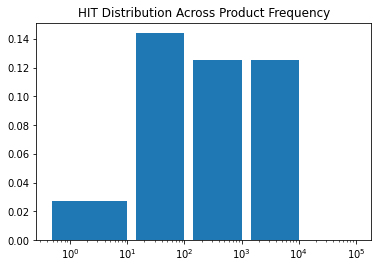

============= TEST RESULTS ===============
Test Type        : hits_distribution
Test Description : Compute the distribution of hit-rate across product frequency in training data
Test Result      : {'histogram': {10: 0.02702702702702703, 100: 0.14410480349344978, 1000: 0.12534818941504178, 10000: 0.125, 100000: 0}, 'counts': {10: 74, 100: 229, 1000: 359, 10000: 128, 100000: 0}}



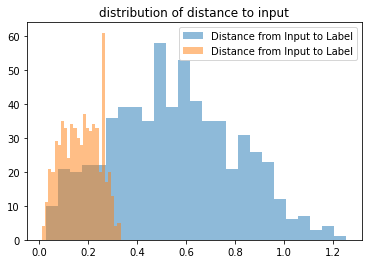

============= TEST RESULTS ===============
Test Type        : distance_to_query
Test Description : Compute the distribution of distance from query to label and query to prediction
Test Result      : {'histogram_x_to_y': ([10, 21, 20, 22, 22, 36, 39, 39, 35, 58, 39, 53, 41, 35, 35, 21, 31, 26, 23, 12, 6, 7, 3, 4, 1], [0.027085185050964355, 0.07621452689170838, 0.1253438687324524, 0.1744732105731964, 0.22360255241394042, 0.27273189425468447, 0.32186123609542844, 0.37099057793617246, 0.4201199197769165, 0.4692492616176605, 0.5183786034584046, 0.5675079452991485, 0.6166372871398925, 0.6657666289806365, 0.7148959708213806, 0.7640253126621246, 0.8131546545028686, 0.8622839963436126, 0.9114133381843567, 0.9605426800251007, 1.0096720218658448, 1.0588013637065887, 1.1079307055473326, 1.1570600473880768, 1.2061893892288207, 1.2553187310695648]), 'histogram_x_to_p': ([4, 11, 21, 20, 29, 28, 35, 33, 24, 34, 33, 30, 28, 37, 33, 32, 34, 33, 20, 61, 17, 20, 13, 4, 5], [0.012268495559692384, 0.0250940

In [ ]:
# instantiate rec_list object
rec_list = CoveoCartRecList(
    model=model,
    dataset=coveo_dataset
)
# invoke rec_list to run tests
rec_list(verbose=True)

---

In [ ]:
!apt-get install tree
!tree -a --du -h . -L 3

.
├── [ 16K]  .config
│   ├── [   7]  active_config
│   ├── [   0]  config_sentinel
│   ├── [4.1K]  configurations
│   │   └── [  94]  config_default
│   ├── [   5]  gce
│   ├── [   3]  .last_opt_in_prompt.yaml
│   ├── [  37]  .last_survey_prompt.yaml
│   ├── [ 135]  .last_update_check.json
│   └── [8.0K]  logs
│       └── [4.0K]  2021.11.18
├── [1.9G]  coveo_reclist
│   └── [1.9G]  coveo_sigir.zip
├── [ 19M]  coveo_sigir.zip
└── [ 12K]  .reclist
    └── [8.0K]  CoveoCartRecList
        └── [4.0K]  P2VRecModel

 1.9G used in 8 directories, 9 files


In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-22 16:35:08

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

json      : 2.0.9
numpy     : 1.21.2
IPython   : 5.5.0
gensim    : 4.0.1
matplotlib: 3.4.3
networkx  : 2.6.3
requests  : 2.22.0



---

**END**